In [3]:
import pandas as pd
import re
import json
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
#import rpy2.robjects as robjects
#from rpy2.robjects import pandas2ri

#### Prepare & Load Data

In [159]:
### Load Data 
gpt3 = "/Users/annaking/Documents/Github/riskychoiceframing_AI/Experiment 2/tests/variable_prompt_test_turbo.csv"
####gpt3 = "/Users/annaking/Documents/Github/riskychoiceframing_AI/Experiment 2/tests/prompt_testing073123_v1.csv"
df_gpt3 = pd.read_csv(gpt3)
df_gpt3.shape

(2705, 8)

In [160]:
##check test runs
df_gpt3.groupby(['test','frame']).size()

test                                                                                               frame      
['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role', 'gain_animal2']  gain_animal      3
['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role']                  gain_animal    102
                                                                                                   gain_human      60
                                                                                                   loss_animal     74
                                                                                                   loss_human      74
                                                                                                                 ... 
['combo 8C3', 'system_message_1C', 'user_message_4_p', 'instructions: task order & output']        loss_human       2
['combo 8D', 'system_message_1_json', 'user_message_6B2', 'inst

In [161]:
### Cleaning

#clean test names
df_gpt3['test'] = df_gpt3['test'].replace("['combo 7', 'system_message_1D', 'user_message_7']", "['combo 7', 'system_message_1B', 'user_message_7']")
##df_gpt3['test'] = df_gpt3['test'].replace("", "['combo 8C3', 'system_message_1C', 'user_message_4', 'instructions: task order & output']")
df_gpt3['test'] = df_gpt3['test'].replace("['combo 4', 'system_message_4', 'user_message_4']", "['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']")
df_gpt3['test'] = df_gpt3['test'].replace("['combo 8A', 'system_message_1C', 'user_message_4', 'instructions: task order & output']", "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']")
df_gpt3['test'] = df_gpt3['test'].replace("['combo 3', 'system_message_1C', 'user_message_baseline1', 'human']", "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']")
df_gpt3['test'] = df_gpt3['test'].replace("['combo 4B', 'system_message_4', 'user_message_5']", "['combo 6B', 'system_message_risk', 'user_message_chain', 'risk + chain']")
df_gpt3['test'] = df_gpt3['test'].replace("['combo 9', 'system_message_1', 'user_message_5']", "['combo 6', 'system_message_1', 'user_message_chain', 'flag for re-run']")
df_gpt3['test'] = df_gpt3['test'].replace("['combo 5', 'system_message_baseline1', 'user_message_q1', 'q1 options']", "['combo 7', 'system_message_baseline1', 'user_message_q1', 'q1 options']")
df_gpt3['test'] = df_gpt3['test'].replace("['combo 8D', 'system_message_1_json', 'user_message_6B2', 'instructions: task order & output']", "['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']")

conditions1 = (df_gpt3['test'] == "['combo 8', 'system_message_1', 'user_message_4']") & (df_gpt3['temperature'] == .7)
df_gpt3.loc[conditions1, 'test'] = "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']"

##beg prompt 
pattern = r'(.*?)\s*Scenario:'
df_gpt3['prompt_start'] = df_gpt3['prompt'].str.extract(pattern,  flags=re.DOTALL)
df_gpt3[['frame', 'scenario']] = df_gpt3['frame'].str.split('_', n=1, expand=True)



In [162]:
## drop bad tests
##drop bad tests 
bad_tests = ["['combo 8C', 'system_message_1_json', 'user_message_6B2', 'instructions: task order & output']",
 "['combo 6', 'system_message_1B', 'user_message_6']", 
 "['combo 8C2', 'system_message_1_jsonjp', 'user_message_4_p', 'instructions: task order & output']",
 "['combo 6D', 'system_message_1B', 'user_message_6B']" , ##included too many changes in user message and odd spacing
 "['combo 6B', 'system_message_1C', 'user_message_6B']", ##mismatch in JSON output instructions
 "['combo 7', 'system_message_1B', 'user_message_7']",##odd spacing and mismatch 
 "['combo 6C', 'system_message_1C', 'user_message_6C']", ##mismatch in JSON output instructions; removed options for question 1 
 "['combo 8C3', 'system_message_1C', 'user_message_4_p', 'instructions: task order & output']" ,##included plural responses 
 ###"['combo 9', 'system_message_1', 'user_message_5']", ##mispelling ###not droppping yet
 "['combo 8A', 'system_message_1C', 'user_message_4', 'instructions: task order & output']" ,
 "['combo 8', 'system_message_1', 'user_message_4']",
 ###"['combo 7', 'system_message_hum', 'user_message_q1', 'q1 options']",
 "['combo 7', 'system_message_baseline1', 'user_message_q1', 'q1 options']", 
 "['combo 5_2', 'system_message_hum_json', 'user_message_taskord_2', 'hum + task order']"	, ### testing the effect of spacing in the sep JSON object
 "['combo 7', 'system_message_hum', 'user_message_noq3', 'hum + simple + noq3']", ##doesnt appear to ahve sig impact 
 "['combo 7B', 'system_message_baseline1', 'user_message_noq3', 'hum + simple + noq3']" ,##doesnt appear to ahve sig impact 
 "['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role', 'gain_animal2']", 
 "['combo 6', 'system_message_1', 'user_message_chain', 'flag for re-run']", ##wrong system message,
 "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human', 'gain_animal3']", ##test for altered animal scenario framing
 "['combo 7', 'system_message_hum', 'user_message_q1', 'q1 options']"
]

df_gpt3 = df_gpt3[~df_gpt3['test'].isin(bad_tests)]

#remove wrong animal gain test
df_gpt3 = df_gpt3[~df_gpt3['prompt'].str.contains('1,000')]

#remove where scenario did not get included 
df_gpt3 = df_gpt3[~(df_gpt3['prompt'].str.contains("""{}""")) & df_gpt3['scenario'].str.contains('animal')]

#drop accidental test duplicate 
condition_gain = (df_gpt3['test'] == "['combo 6B', 'system_message_risk', 'user_message_chain', 'risk + chain']") & (df_gpt3['scenario'] == 'human') & (df_gpt3['frame'] == 'gain') & (df_gpt3['temperature'] == 0)
condition_loss = (df_gpt3['test'] == "['combo 6B', 'system_message_risk', 'user_message_chain', 'risk + chain']") & (df_gpt3['scenario'] == 'human') & (df_gpt3['frame'] == 'loss') & (df_gpt3['temperature'] == 0)
drop_gain = df_gpt3[condition_gain].index[-30:]  # We only want the last 37 instances.
drop_loss = df_gpt3[condition_loss].index[-37:]  # We only want the last 37 instances.

df_gpt3 = df_gpt3.drop(drop_gain)
df_gpt3 = df_gpt3.drop(drop_loss)

In [163]:
##clean json 
# import json 
def clean_json(x):
    x = x.strip("'")  # remove leading/trailing single quotes
    x = x.strip("\n")  # remove leading/trailing newline characters
    x = x.encode('utf-8', 'ignore').decode('utf-8')  # ignore non utf-8 characters
    x = re.sub(r'"\s*"', '","', x)  # replace spaces between quotes with commas
    #replace incorrect JSON keys with correct keys
    for key in ["Q1_Response", "Q2_Response", "Q3_Response"]:
        x = re.sub(f'(?<=[{{,])\s*{key}\s*(?=:)', f' "{key}"', x)
    # make sure quotes 
    x = re.sub(r':\s*([0-9]+)\s*(?=[,}])', r': "\1"', x)

    # cleaning steps
    x = x.replace('Q1_response','Q1_Response')
    x = x.replace('Q2_response','Q2_Response')
    x = x.replace('Q3_response','Q3_Response')
    x = x.replace('it"s', 'it\'s')
    x = x.replace('B"s', "B's")
    x = x.replace("}, {", ",")
    x = x.replace("},{", ",")

    for proposal in ["Proposal A", "Proposal B"]:
        x = re.sub(f'(?<=:)\s*{proposal}(?=\s*[^"]\w*,)', f' "{proposal}"', x)
    x = re.sub(r'}\s*{', ', ', x)
    if not x.startswith('{'):
        x = '{' + x
    if not x.endswith('}'):
        x = x + '}'
    try:
        x = x.replace('\n', ' ')
        x = json.dumps(json.loads(x))
    except json.JSONDecodeError:
        return x
    return x

def try_loads(x):
    try:
        return pd.Series(json.loads(x))
    except json.JSONDecodeError:
        print(f"Error decoding: {x}")
        return pd.Series()

df_gpt3['response'] = df_gpt3['response'].apply(clean_json)
responses = df_gpt3.apply(lambda x: pd.Series(json.loads(x['response'])), axis=1, result_type='expand')
df_gpt3 = pd.concat([df_gpt3, responses], axis = 1)
df_gpt3 = df_gpt3.reset_index()
df_gpt3['Q1_Response']  = df_gpt3['Q1_Response'].apply(lambda x: 'Proposal B' if x == 'Option B' else x)
df_gpt3['Q1_Response']  = df_gpt3['Q1_Response'].apply(lambda x: 'Proposal A' if x == 'Option A' else x)

###responses = df_gpt3['response'].apply(try_loads)

In [164]:
df_gpt3['test'].unique()

array(["['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role']",
       "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']",
       "['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']",
       "['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']",
       "['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']",
       "['combo 6', 'system_message_hum', 'user_message_chain', 'hum + chain']",
       "['combo 6B', 'system_message_risk', 'user_message_chain', 'risk + chain']"],
      dtype=object)

In [165]:
##define variables for each test 
import ast
test_dict = {
    "['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role']": "['neutral_system','simple','neutral_risk']",
    "['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']":"['human','simple', 'neutral_risk']",
    "['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']":"['human','simple', 'risk']",  
    "['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']": "['human','task_order', 'neutral_risk']",
    "['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']": "['human','task_order', 'risk']",
    "['combo 6', 'system_message_1', 'user_message_chain', 'flag for re-run']": "['human','chain','neutral_risk' ]",
    "['combo 6', 'system_message_hum', 'user_message_chain', 'hum + chain']": "['human','chain','neutral_risk' ]",
    "['combo 6B', 'system_message_risk', 'user_message_chain', 'risk + chain']": "['human','chain','risk']"
    }

var_dict = {'sys_role': ['human', 'neutral_system'],
            'instructions': ['simple', 'chain', 'task_order'],
            'risk': ['neutral_risk', 'risk']}

df_copy2 = df_gpt3.copy()


new_test_dict = {}
for key, value in test_dict.items():
    new_key = ast.literal_eval(key)
    new_value = ast.literal_eval(value)
    new_test_dict[tuple(new_key)] = new_value


def map_values(test_name):
    # Dictionary to hold our results
    result = {}
    
    test_list = ast.literal_eval(test_name)
    variable_list = test_dict.get(test_name, [])
    
    # Iterate over the variable dictionary
    for var_type, values in var_dict.items():
        # Check if any value from var_dict is in the variable_list
        for val in values:
            if val in variable_list:
                result[var_type] = val
                break  # break once we find a match
                
    # Return as a Series
    return pd.Series(result)
df_gpt3 = df_gpt3.join(df_gpt3['test'].apply(map_values))

##order into dummies 
ins = ['simple', 'chain', 'task_order']
sys = ['human', 'neutral_system']
rsk = ['neutral_risk', 'risk']

df_gpt3['instructions'] = df_gpt3['instructions'].astype('category').cat.reorder_categories(ins, ordered=True)
df_gpt3['sys_role'] = df_gpt3['sys_role'].astype('category').cat.reorder_categories(sys, ordered=True)
df_gpt3['risk'] = df_gpt3['risk'].astype('category').cat.reorder_categories(rsk, ordered=True)


In [168]:
#Option Selected
df_gpt3['option_selected'] =  df_gpt3['Q1_Response']

In [169]:
####Rating Data 

import re
df_gpt3['Q2_Response'] = df_gpt3['Q2_Response'].astype('str')
df_gpt3['rating_num'] = df_gpt3['Q2_Response'].str.extract(r'(\d+)')

#remove where rating is missing 
df_gpt3 = df_gpt3[~df_gpt3['rating_num'].isna()]
df_gpt3['rating_num'] = df_gpt3['rating_num'].astype('int')

##categorize
ratings =  { 'Strong Preference for Proposal A': 1, 2: 'Preference for Proposal A', 3:'Slight Preference for Proposal A',  4:'No Preference for Proposal A or B',  5:'Slight Preference for Propsal B',  6:'Preference for Proposal B',7:'Strong Preference for Proposal B'}
df_gpt3['rating_num'] = pd.to_numeric(df_gpt3['rating_num'], errors='coerce')
df_gpt3['rating_cat'] = df_gpt3['rating_num'].map(ratings)
df_gpt3 = df_gpt3[~df_gpt3['rating_num'].isna()]
df_gpt3['rating_cat'] = df_gpt3['rating_num'].map(ratings)

In [ ]:
### Create Dummy Variables 


##prompt variables 
sys_role_dummy = pd.get_dummies(df_gpt3['sys_role'], prefix='sys_role', drop_first=True)
instructions_dummy  = pd.get_dummies(df_gpt3['instructions'], prefix='instructions', drop_first=True)
risk_dummy = pd.get_dummies(df_gpt3['risk'], prefix='risk', drop_first=True)



In [167]:
##save for cross compare 
df_gpt3.to_csv('df_gpt3.csv')

#### Look at each Test Result

In [170]:
##Choice Cross tab 
pd.set_option('display.max_colwidth', None)
df_cross_tab = pd.crosstab([df_gpt3['test'] ,  df_gpt3['frame']] ,[df_gpt3['temperature'], df_gpt3['Q1_Response']]) ###

new_columns = []
for column in df_cross_tab.columns:
    if isinstance(column, tuple):  # this will be true for the temperature-related columns
        if column[0] == 0.0 and column[1] == 'Proposal A':
            new_columns.append('PA_t0')
        elif column[0] == 0.0 and column[1] == 'Proposal B':
            new_columns.append('PB_t0')
        elif column[0] == 0.7 and column[1] == 'Proposal A':
            new_columns.append('PA_t.7')
        elif column[0] == 0.7 and column[1] == 'Proposal B':
            new_columns.append('PB_t.7')
        elif column[0] == 1 and column[1] == 'Proposal A':
            new_columns.append('PA_t1')
        else: 
             new_columns.append('PB_t1')
    else:  # this will be true for 'test' and 'frame' columns
        new_columns.append(column)
df_cross_tab.columns = new_columns
df_cross_tab.reset_index(inplace=True)
df_cross_tab

,test,frame,PA_t0,PB_t0,PA_t.7,PB_t.7
0,"['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role']",gain,0,34,0,34
1,"['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role']",loss,37,0,23,14
2,"['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']",gain,0,34,2,32
3,"['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']",loss,37,0,16,21
4,"['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']",gain,0,34,8,26
5,"['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']",loss,37,0,64,10
6,"['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']",gain,0,34,2,31
7,"['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']",loss,0,37,15,21
8,"['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']",gain,0,34,2,28
9,"['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']",loss,37,0,22,13


In [172]:
###Prop A Crosstab
df_cross_tab['PA_t0_pct'] = (df_cross_tab['PA_t0'] / (df_cross_tab['PA_t0'] + df_cross_tab['PB_t0']))*100
df_cross_tab['PA_t0_pct'] = df_cross_tab['PA_t0_pct'].round(2)
##df_cross_tab['PA_t1_pct'] = (df_cross_tab['PA_t1'] / (df_cross_tab['PA_t1'] + df_cross_tab['PB_t1']))
##df_cross_tab['PA_t1_pct'] = df_cross_tab['PA_t1_pct'].round(2)
df_cross_tab['PA_t.7_pct'] = (df_cross_tab['PA_t.7'] / (df_cross_tab['PA_t.7'] + df_cross_tab['PB_t.7']))*100
df_cross_tab['PA_t.7_pct'] = df_cross_tab['PA_t.7_pct'].round(2)
###prop_A = df_cross_tab.drop(columns = ['PA_t0','PB_t0', 'PA_t.7', 'PB_t.7', 'PA_t1', 'PB_t1'])
prop_A = df_cross_tab.drop(columns = ['PA_t0','PB_t0', 'PA_t.7', 'PB_t.7'])
prop_A

,test,frame,PA_t0_pct,PA_t.7_pct
0,"['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role']",gain,0.0,0.00
1,"['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role']",loss,100.0,62.16
2,"['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']",gain,0.0,5.88
3,"['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']",loss,100.0,43.24
4,"['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']",gain,0.0,23.53
5,"['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']",loss,100.0,86.49
6,"['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']",gain,0.0,6.06
7,"['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']",loss,0.0,41.67
8,"['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']",gain,0.0,6.67
9,"['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']",loss,100.0,62.86


In [175]:
##Rating Crosstab
t0 = 
rating_cross_t0 = pd.crosstab(df_gpt3['test'] ,[df_gpt3['temperature'],df_gpt3['frame']], values = df_gpt3['rating_num'], aggfunc= 'mean')
rating_cross

temperature                                                                                 0.0  \
frame                                                                                      gain   
test                                                                                              
['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role']      6.000000   
['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']                   6.000000   
['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']            6.000000   
['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']     6.617647   
['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']  6.000000   
['combo 6', 'system_message_hum', 'user_message_chain', 'hum + chain']                 6.000000   
['combo 6B', 'system_message_risk', 'user_message_chain', 'risk + chain']              5.000000   

temperature                                                                                 \
frame                                                                                 loss   
test                                                                                         
['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role']      2.0   
['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']                   2.0   
['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']            2.0   
['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']     7.0   
['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']  3.0   
['combo 6', 'system_message_hum', 'user_message_chain', 'hum + chain']                 6.0   
['combo 6B', 'system_message_risk', 'user_message_chain', 'risk + chain']              3.0   

temperature                                                                                 0.7  \
frame                                                                                      gain   
test                                                                                              
['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role']      5.911765   
['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']                   5.852941   
['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']            4.852941   
['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']     6.030303   
['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']  5.633333   
['combo 6', 'system_message_hum', 'user_message_chain', 'hum + chain']                      NaN   
['combo 6B', 'system_message_risk', 'user_message_chain', 'risk + chain']              4.500000   

temperature                                                                                      
frame                                                                                      loss  
test                                                                                             
['combo 1A', 'system_message_baseline1', 'user_message_baseline1', 'system role']      3.837838  
['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']                   4.540541  
['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']            3.000000  
['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']     4.861111  
['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']  3.914286  
['combo 6', 'system_message_hum', 'user_message_chain', 'hum + chain']                      NaN  
['combo 6B', 'system_message_risk', 'user_message_chain', 'risk + chain']              3.135135

#### Descriptive Stats

In [35]:
print(df_gpt3['option_selected'].value_counts(normalize=True))
print('\n\n')
print(df_gpt3.groupby('frame')['option_selected'].value_counts(normalize=True))

option_selected
Proposal A    0.605655
Proposal B    0.394345
Name: proportion, dtype: float64



frame  option_selected
gain   Proposal B         0.501534
       Proposal A         0.498466
loss   Proposal A         0.706647
       Proposal B         0.293353
Name: proportion, dtype: float64


<Axes: xlabel='rating_num', ylabel='Count'>

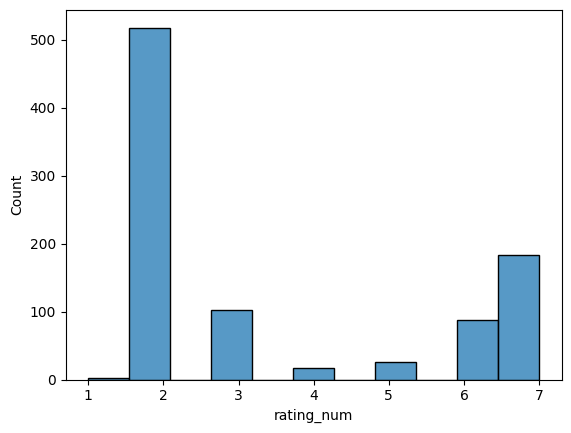

In [404]:
##Graphing

sns.histplot(df_gpt3['rating_num'])

#### Tests for Hypotheses

H1 & H2: Framing Effect and Preference Ratings

In [43]:
###H1: Chi-squared Test (or Fisher's Exact Test) for Option Selected:
contingency_table = pd.crosstab(df_gpt3['frame'], df_gpt3['option_selected'])
chi2, pval, _, _ = stats.chi2_contingency(contingency_table)

###H2: Kruskal-Wallis Test for Rating ##CHECK
stat, p_val2 = stats.mannwhitneyu(df_gpt3[df_gpt3['frame']=='gain']['rating_num'], df_gpt3[df_gpt3['frame']=='loss']['rating_num'])


###Output as a table
results = {
    ('option selected'): {
        'chi2/stat': chi2,
        'p_val': pval,
        'sig effect': pval < .05
    },
    ('rating number'): {
        'chi2/stat': stat,
        'p_val': p_val2,
        'sig effect': p_val2 < .05
    }}

df_op = pd.DataFrame.from_dict(results)
df_op



,option selected,rating number
chi2/stat,60.048045,261117.5
p_val,0.0,0.0
sig effect,True,True


H3 - H5: Influence of Prompt 

In [452]:
############## ---- Instructions ---- ###############
#Instructions (Op Selected)
ins_cont_table = pd.crosstab(df_gpt3['instructions'], df_gpt3['option_selected'])
chi2_i, pval_i, _, _ = stats.chi2_contingency(ins_cont_table)
#Instructions (Rating)
stat_i, pval_i2 = stats.kruskal(df_gpt3[df_gpt3['instructions']=='simple']['rating_num'], df_gpt3[df_gpt3['instructions']=='chain']['rating_num'], df_gpt3[df_gpt3['instructions']=='task_order']['rating_num'])

############## ---- System Role ---- ###############

#Sys Role (Op Selected)
sys_cont_table = pd.crosstab(df_gpt3['sys_role'], df_gpt3['option_selected'])
chi2_s, pval_s, _, _ = stats.chi2_contingency(ins_cont_table)
#Sys Rol (Rating)
stat_s, pval_s2= stats.kruskal(df_gpt3[df_gpt3['sys_role']=='neutral']['rating_num'], df_gpt3[df_gpt3['sys_role']=='human']['rating_num'])

############## ---- Risk ---- ###############

#Risk (Op Selected)
risk_cont_table = pd.crosstab(df_gpt3['risk'], df_gpt3['option_selected'])
chi2_r, pval_r, _, _ = stats.chi2_contingency(ins_cont_table)
#Risk (Rating)
stat_r, pval_r2= stats.kruskal(df_gpt3[df_gpt3['risk']=='neutral']['rating_num'], df_gpt3[df_gpt3['risk']=='risk']['rating_num'])

############## ---- Temp ---- ###############
#Temp (Op Selected)
risk_cont_table = pd.crosstab(df_gpt3['temperature'], df_gpt3['option_selected'])
chi2_t, pval_t, _, _ = stats.chi2_contingency(ins_cont_table)
#Temp (Rating)
stat_t, pval_t2= stats.kruskal(df_gpt3[df_gpt3['temperature']==0]['rating_num'], df_gpt3[df_gpt3['temperature']==.7]['rating_num'])

Instructions (Op Selected):
chi2: 299.5451369311459
p_val: 9.007410901799086e-66
sig effect? True

Instructions (Rating):
stat: 297.9887465175072
pval: 1.961398591486372e-65
sig effect? True

--------
Sys Role (Op Selected):
chi2: 299.5451369311459
p_val: 9.007410901799086e-66
sig effect? True

Sys Role (Rating):
stat: 33.35790932947023
pval: 7.666538691592727e-09
sig effect? True

--------
Risk (Op Selected):
chi2: 299.5451369311459
p_val: 9.007410901799086e-66
sig effect? True

Risk (Rating):
stat: 0.0924507254640579
pval: 0.7610843828582734
sig effect? False

--------\Temp (Op Selected):
chi2: 299.5451369311459
p_val: 9.007410901799086e-66
sig effect? True
\Temp (Rating):
stat: 25.00564993227043
pval: 5.716256362741587e-07
sig effect? True


In [458]:
###Output as a table
dict_instructions = {
    ('instructions', 'option selected'): {
        'chi2/stat': chi2_i,
        'p_val': pval_i,
        'sig effect': pval_i < .05
    },
    ('instructions', 'rating number'): {
        'chi2/stat': stat_i,
        'p_val': pval_i2,
        'sig effect': pval_i2 < .05
    }
}
dict_sys_role = {
    ('sys role', 'option selected'): {
        'chi2/stat': chi2_s,
        'p_val': pval_s,
        'sig effect': pval_s < .05
    },
    ('sys role', 'rating number'): {
        'chi2/stat': stat_s,
        'p_val': pval_s2,
        'sig effect': pval_s2 < .05
    }
}
dict_risk = {
    ('risk', 'option selected'): {
        'chi2/stat': chi2_r,
        'p_val': pval_r,
        'sig effect': pval_r < .05
    },
    ('risk', 'rating number'): {
        'chi2/stat': stat_r,
        'p_val': pval_r2,
        'sig effect': pval_r2 < .05
    }
}
dict_temp = {
    ('temp', 'option selected'): {
        'chi2/stat': chi2_t,
        'p_val': pval_t,
        'sig effect': pval_t < .05
    },
    ('temp', 'rating number'): {
        'chi2/stat': stat_t,
        'p_val': pval_t2,
        'sig effect': pval_t2 < .05,
    }
}
df_instructions = pd.DataFrame(dict_instructions)
df_sys_role = pd.DataFrame(dict_sys_role)
df_risk = pd.DataFrame(dict_risk)
df_temp = pd.DataFrame(dict_temp)
test_results_df = pd.concat([df_instructions, df_sys_role, df_risk, df_temp], axis=1)


instructions                      sys role                \
           option selected rating number option selected rating number   
chi2/stat       299.545137    297.988747      299.545137     33.357909   
p_val                  0.0           0.0             0.0           0.0   
sig effect            True          True            True          True   

                      risk                          temp                
           option selected rating number option selected rating number  
chi2/stat       299.545137      0.092451      299.545137      25.00565  
p_val                  0.0      0.761084             0.0      0.000001  
sig effect            True         False            True          True

#### Statistics 

In [11]:
##prep variables 
from sklearn import preprocessing
le = preprocessing.LabelEncoder()


##data cleaning & dummy coding 
df_gpt3_w_dummy = pd.get_dummies(df_gpt3, columns=['test'], prefix='participant_type', drop_first=True)
    #participant_type_['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']	
    #participant_type_['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']	   
    #participant_type_['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']	
    #participant_type_['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']		
    #participant_type_['combo 6', 'system_message_1', 'user_message_chain', 'flag for re-run']	
    #participant_type_['combo 6B', 'system_message_risk', 'user_message_chain', 'risk + chain']
    
##cat code temperature variable 

##rename variables for 
df_gpt3_w_dummy= df_gpt3_w_dummy.rename(columns = {
    "participant_type_['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']":'human', 
    "participant_type_['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']": 'hum_risk',
    "participant_type_['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']": 'hum_taskord',
    "participant_type_['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']": 'hum_risk_taskord',
    "participant_type_['combo 6', 'system_message_1', 'user_message_chain', 'flag for re-run']": 'hum_chain',
    "participant_type_['combo 6B', 'system_message_risk', 'user_message_chain', 'risk + chain']": 'hum_risk_chain'
    })
dummy_cols = ['human', 'hum_risk', 'hum_taskord', 'hum_risk_taskord', 'hum_chain', 'hum_risk_chain']
df_gpt3_w_dummy[dummy_cols] = df_gpt3_w_dummy[dummy_cols].astype(int)



df_gpt3['temp_var'] = df_gpt3.temperature.astype('category').cat.codes ##temp 0 = 0; temp .7 = 1

df_gpt3['frame_cat'] = le.fit_transform(df_gpt3['frame']) ##0 = gain, 1 = loss
df_gpt3['frame_rev'] = 1 - df_gpt3['frame_cat'] ##1 = gain, 0 = loss


df_gpt3['option_selected_cat'] = le.fit_transform(df_gpt3['option_selected']) ##0 = Prop A, 1 = Prop B
df_gpt3['option_selected_rev'] = 1 - df_gpt3['option_selected_cat'] ##1 = Prop A, 0 = Prop B



In [16]:
robjects.r('install.packages("stargazer", repos="https://cran.r-project.org/")')
robjects.r('library(stargazer)')

R[write to console]: trying URL 'https://cran.r-project.org/bin/macosx/big-sur-arm64/contrib/4.2/stargazer_5.2.3.tgz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 616438 bytes (601 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to cons


The downloaded binary packages are in
	/var/folders/vv/15vmsdzj0d9c0x2z42fx60fr0000gn/T//RtmplKPxdU/downloaded_packages


R[write to console]: 
Please cite as: 


R[write to console]:  Hlavac, Marek (2022). stargazer: Well-Formatted Regression and Summary Statistics Tables.

R[write to console]:  R package version 5.2.3. https://CRAN.R-project.org/package=stargazer 




'stargazer','tools','stats',...,'datasets','methods','base'


In [17]:
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
pandas2ri.activate()

### R Packages
##R = robjects.r
##robjects.r('options(repos = c(CRAN="https://cran.r-project.org/"))')
##robjects.r('install.packages("ggplot2")')
##robjects.r('install.packages("glm")')
##R('library(glm)')
#robjects.r('install.packages("broom", repos="https://cran.r-project.org/")')
#robjects.r('library(broom)')
##robjects.r('install.packages("stargazer", repos="https://cran.r-project.org/")')
##robjects.r('library(stargazer)')



R = robjects.r

df_gpt3_r = pandas2ri.py2rpy(df_gpt3)


formula = 'option_selected_cat ~ frame_cat'
model = R.glm(formula, data=df_gpt3, family="binomial")
summary_output = robjects.r('stargazer')(model, type="text")
print(summary_output[0])



R[write to console]: Error in if (is.na(s)) { : the condition has length > 1



RRuntimeError: Error in if (is.na(s)) { : the condition has length > 1


In [319]:
##split into conditions 
gain_df = df_gpt3[df_gpt3['frame'] == 'gain']
loss_df = df_gpt3[df_gpt3['frame'] == 'loss']

##cohen's d ##FIX 
####mean_difference = gain_df['rating_num'].mean() - loss_df['rating_num'].mean()
##pooled_std = ((gain_df['rating_num'].std() ** 2 + loss_df.std() ** 2) / 2) ** 0.5
##cohen_d = mean_difference / pooled_std
##cohen_d


Hypothesis 1: All AI models will exhibit the risky choice framing effect.

In [372]:
import statsmodels.formula.api as smf
##frame_rev: 0 = loss, 1 = gain
##frame_cat: 0 = gain, 1 = loss
#option_selected_rev: 0 = B; 1 = A
#option_selected_cat: 0 = A; 1 = B


logit_reg_rev = smf.logit('option_selected_rev ~ frame_rev', df_gpt3).fit()
print("frame coeff:", logit_reg_rev.params[1])
print("frame p-vale:", logit_reg_rev.pvalues[1])
print(logit_reg_rev.summary())
#intercept coef 0.7516, represents the log odds of selecting Proposal A when the frame is "loss" (coded as 0)
##frame coef of 0.0094, represents the change in the log odds of selecting Proposal B when the frame changes from "gain" to "loss." ---> "there is no significant effect of the "loss" frame condition on the choice of Proposal B."

logit_reg = smf.logit('option_selected_cat ~ frame_cat', df_gpt3).fit()
print("frame coeff:", logit_reg_rev.params[1])
print("frame p-vale:", logit_reg_rev.pvalues[1])
#intercept coef -0.7582, represents the log odds of selecting Proposal B when the frame is "gain" (coded as 0)
##frame coef of 0.0094, represents the change in the log odds of selecting Proposal B when the frame changes from "gain" to "loss." ---> "there is no significant effect of the "loss" frame condition on the choice of Proposal B."

Optimization terminated successfully.
         Current function value: 0.626221
         Iterations 4
frame coeff: 0.013477292943490898
frame p-vale: 0.9236959709917028
                            Logit Regression Results                           
Dep. Variable:     option_selected_rev   No. Observations:                  940
Model:                           Logit   Df Residuals:                      938
Method:                            MLE   Df Model:                            1
Date:                 Wed, 09 Aug 2023   Pseudo R-squ.:               7.793e-06
Time:                         19:19:06   Log-Likelihood:                -588.65
converged:                        True   LL-Null:                       -588.65
Covariance Type:             nonrobust   LLR p-value:                    0.9237
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.7516      0.094 

In [378]:
np.exp(logit_reg_rev.params)
#Intercept    2.120482
#frame_rev    1.013569 ##odds ratio that associates gain frame with choosing certain option 
##gain group has 1.36% more odds of being in prop A than the loss frame 
##there is a 
(1.013569 - 1)

0.013568999999999942

<Axes: ylabel='Count'>

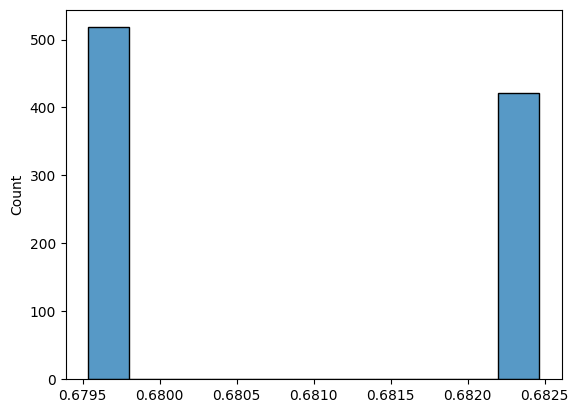

In [371]:
import seaborn as sns
histogram of porbabilites 
##proba = 1 / (1 + np.exp( - logit_reg_rev.fittedvalues ))
sns.histplot(proba)

In [330]:
##add in interaction term for test
logit_reg_test = smf.logit('option_selected_cat ~ frame * test', df_gpt3).fit()
print("frame coeff:", logit_reg_test.params[1])
print("frame p-vale:", logit_reg_test.pvalues[1])

##add in interaction term for temp
logit_reg_temp = smf.logit('option_selected_cat ~ frame * temperature', df_gpt3).fit()
print("frame coeff:", logit_reg_temp.params[1])
print("frame p-vale:", logit_reg_temp.pvalues[1])
logit_reg_temp.summary()

Optimization terminated successfully.
         Current function value: 0.456600
         Iterations 7
frame coeff: 0.5415972824327303
frame p-vale: 0.3485484838742352
Optimization terminated successfully.
         Current function value: 0.614978
         Iterations 5
frame coeff: 0.33950714031635837
frame p-vale: 0.11443433350338518


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                           
===============================================================================
Dep. Variable:     option_selected_cat   No. Observations:                  940
Model:                           Logit   Df Residuals:                      936
Method:                            MLE   Df Model:                            3
Date:                 Sat, 05 Aug 2023   Pseudo R-squ.:                 0.01796
Time:                         01:45:18   Log-Likelihood:                -578.08
converged:                        True   LL-Null:                       -588.65
Covariance Type:             nonrobust   LLR p-value:                 9.811e-05
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    -1.2558      0.165     -7.595      0.000      -1.580      -0.932
frame[T.loss]                 0.3395      0.215      1.579      0.114      -0.082       0.761
temperature                   1.2993      0.310      4.197      0.000       0.693       1.906
frame[T.loss]:temperature    -0.8421      0.411     -2.049      0.040      -1.647      -0.037
=============================================================================================
"""

In [329]:
##add in interaction term for temp & model 

logit_reg_temptest = smf.logit('option_selected_cat ~ frame * test + frame * temperature ', df_gpt3).fit()
print("frame coeff:", logit_reg_temptest.params[1])
print("frame p-vale:", logit_reg_temptest.pvalues[1])
logit_reg_temptest.summary()
#framing effect is positive, but not significant 
##temperature has a positive and significant effect, suggesting that increasing temperature increases the odds of 'option_selected_cat'.
##interaction term frame[T.loss]:temperature is negative and significant, indicating that for loss-framed scenarios, increasing temperature decreases the odds of  selecting Option B compared to gain-framed scenarios.

Optimization terminated successfully.
         Current function value: 0.440755
         Iterations 7
frame coeff: 1.0695059164404142
frame p-vale: 0.09188382689796289


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                           
===============================================================================
Dep. Variable:     option_selected_cat   No. Observations:                  940
Model:                           Logit   Df Residuals:                      924
Method:                            MLE   Df Model:                           15
Date:                 Sat, 05 Aug 2023   Pseudo R-squ.:                  0.2962
Time:                         01:43:28   Log-Likelihood:                -414.31
converged:                        True   LL-Null:                       -588.65
Covariance Type:             nonrobust   LLR p-value:                 3.956e-65
===============================================================================================================================================================================
                                                                                                                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                                      -3.2113      0.515     -6.237      0.000      -4.220      -2.202
frame[T.loss]                                                                                                   1.0695      0.635      1.686      0.092      -0.174       2.313
test[T.['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']]                                   -0.2635      0.705     -0.374      0.709      -1.645       1.118
test[T.['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']]                             1.5458      0.560      2.760      0.006       0.448       2.643
test[T.['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']]                      3.7690      0.576      6.541      0.000       2.640       4.898
test[T.['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']]                   3.0909      0.556      5.556      0.000       2.000       4.181
test[T.['combo 6', 'system_message_1', 'user_message_chain', 'flag for re-run']]                                0.8187      0.592      1.383      0.167      -0.341       1.979
test[T.['combo 6B', 'system_message_risk', 'user_message_chain', 'risk + chain']]                               1.4554      0.563      2.587      0.010       0.353       2.558
frame[T.loss]:test[T.['combo 2', 'system_message_hum', 'user_message_baseline1', 'human']]                     -0.5093      0.910     -0.559      0.576      -2.294       1.275
frame[T.loss]:test[T.['combo 3', 'system_message_risk', 'user_message_baseline1', 'risk system']]              -0.9719      0.715     -1.360      0.174      -2.373       0.429
frame[T.loss]:test[T.['combo 5', 'system_message_hum_json', 'user_message_taskord', 'hum + task order']]       -0.4983      0.731     -0.681      0.496      -1.932       0.935
frame[T.loss]:test[T.['combo 5B', 'system_message_risk_json', 'user_message_taskord', 'risk + task order']]    -0.1304      0.707     -0.185      0.854      -1.515       1.254
frame[T.loss]:test[T.['combo 6', 'system_message_1', 'user_message_chain', 'flag for re-run']]                 -0.6028      0.753     -0.800      0.424      -2.079       0.873
frame[T.loss]:test[T.['combo 6B', 'system_message_risk', 'user_message_chain', 'risk + chain']]                -1.5772      0.749     -2.107      0.035      -3.045      -0.110
temperature                                                                                                     1.8456      0.386      4.780      0.000       1.089       2.602
frame[T.loss]:temperature                                       

In [338]:
##indp. variables for prompt 
##should i be dummy coding? 
logit_prompts = smf.logit('option_selected_cat ~ frame * temperature + frame * sys_role + frame * instructions + frame * risk', df_gpt3).fit()
logit_prompts.summary()

Optimization terminated successfully.
         Current function value: 0.452222
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                           
===============================================================================
Dep. Variable:     option_selected_cat   No. Observations:                  940
Model:                           Logit   Df Residuals:                      928
Method:                            MLE   Df Model:                           11
Date:                 Sat, 05 Aug 2023   Pseudo R-squ.:                  0.2779
Time:                         01:54:43   Log-Likelihood:                -425.09
converged:                        True   LL-Null:                       -588.65
Covariance Type:             nonrobust   LLR p-value:                 1.659e-63
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                   -2.2241      0.327     -6.802      0.000      -2.865      -1.583
frame[T.loss]                                0.0771      0.449      0.172      0.864      -0.802       0.957
sys_role[T.neutral]                         -0.6714      0.553     -1.215      0.224      -1.754       0.412
instructions[T.simple]                      -0.2913      0.337     -0.865      0.387      -0.951       0.369
instructions[T.task_order]                   2.2548      0.318      7.090      0.000       1.631       2.878
risk[T.risk]                                 0.3766      0.261      1.444      0.149      -0.135       0.888
frame[T.loss]:sys_role[T.neutral]            0.6808      0.704      0.967      0.333      -0.699       2.060
frame[T.loss]:instructions[T.simple]         0.2913      0.475      0.614      0.539      -0.639       1.222
frame[T.loss]:instructions[T.task_order]     0.7988      0.444      1.798      0.072      -0.072       1.670
frame[T.loss]:risk[T.risk]                  -0.2467      0.365     -0.676      0.499      -0.962       0.468
temperature                                  1.7989      0.380      4.731      0.000       1.054       2.544
frame[T.loss]:temperature                   -1.0637      0.514     -2.069      0.039      -2.071      -0.056
============================================================================================================
"""

In [344]:
###run for all prompt types 
##dummy coding needed? ??????????????
##should there b interaction for all terms????/
logit_dummies = smf.logit('option_selected_cat ~ frame * temperature + frame * human + frame * hum_risk + frame * hum_taskord  + frame * hum_chain + frame * hum_risk_chain', df_gpt3_w_dummy).fit()
logit_dummies.summary()

Optimization terminated successfully.
         Current function value: 0.496600
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                           
===============================================================================
Dep. Variable:     option_selected_cat   No. Observations:                  940
Model:                           Logit   Df Residuals:                      926
Method:                            MLE   Df Model:                           13
Date:                 Sat, 05 Aug 2023   Pseudo R-squ.:                  0.2070
Time:                         02:06:47   Log-Likelihood:                -466.80
converged:                        True   LL-Null:                       -588.65
Covariance Type:             nonrobust   LLR p-value:                 1.301e-44
================================================================================================
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       -1.2289      0.246     -5.002      0.000      -1.710      -0.747
frame[T.loss]                    0.7647      0.318      2.407      0.016       0.142       1.388
temperature                      1.6048      0.353      4.544      0.000       0.913       2.297
frame[T.loss]:temperature       -0.9852      0.474     -2.079      0.038      -1.914      -0.057
human                           -2.1227      0.559     -3.800      0.000      -3.218      -1.028
frame[T.loss]:human             -0.2748      0.745     -0.369      0.712      -1.735       1.186
hum_risk                        -0.3298      0.356     -0.927      0.354      -1.027       0.368
frame[T.loss]:hum_risk          -0.7241      0.485     -1.494      0.135      -1.674       0.226
hum_taskord                      1.8452      0.369      4.995      0.000       1.121       2.569
frame[T.loss]:hum_taskord       -0.2144      0.499     -0.430      0.667      -1.192       0.763
hum_chain                       -1.0463      0.406     -2.578      0.010      -1.842      -0.251
frame[T.loss]:hum_chain         -0.3644      0.541     -0.674      0.501      -1.425       0.696
hum_risk_chain                  -0.4186      0.360     -1.162      0.245      -1.125       0.287
frame[T.loss]:hum_risk_chain    -1.3290      0.534     -2.490      0.013      -2.375      -0.283
================================================================================================
"""

In [199]:
##This model aims to examine how the combination of the frame condition and the temperature setting influences the likelihood of selecting Proposal B (risky option).
print("Outcome: The framing effect is stronger or weaker at different temperature settings.")

#logit_reg_T = smf.logit('option_selected_cat ~ frame + temp_var', df_gpt3).fit()
logit_reg_T = smf.logit('option_selected_cat ~ frame : temp_var', df_gpt3).fit()
logit_reg_T.summary()


Outcome: The framing effect is stronger or weaker at different temperature settings.
Optimization terminated successfully.
         Current function value: 0.616674
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                           
===============================================================================
Dep. Variable:     option_selected_cat   No. Observations:                  937
Model:                           Logit   Df Residuals:                      934
Method:                            MLE   Df Model:                            2
Date:                 Fri, 04 Aug 2023   Pseudo R-squ.:                 0.01647
Time:                         23:32:34   Log-Likelihood:                -577.82
converged:                        True   LL-Null:                       -587.50
Covariance Type:             nonrobust   LLR p-value:                 6.290e-05
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -1.0621      0.105    -10.072      0.000      -1.269      -0.855
frame[gain]:temp_var     0.7323      0.176      4.167      0.000       0.388       1.077
frame[loss]:temp_var     0.4719      0.167      2.820      0.005       0.144       0.800
========================================================================================
"""

In [354]:
### Check for collinarity in prompt variables 

from statsmodels.stats.outliers_influence import variance_inflation_factor
# Define the predictor variables based on your model
X = df_gpt3_w_dummy[[
    'frame_cat', 'temperature', 'human', 'hum_risk', 
    'hum_taskord', 'hum_chain', 'hum_risk_chain'
]]

X = sm.add_constant(X)

# Drop rows with missing or infinite values before calculating VIF
X = X.replace([np.inf, -np.inf], np.nan).dropna()

# Create a new data frame for the VIF data
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns

# Calculate and add the VIF to the data frame
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

print(vif_data)




          feature       VIF
0           const  5.735106
1       frame_cat  1.000038
2     temperature  1.000032
3           human  1.289421
4        hum_risk  1.286170
5     hum_taskord  1.286170
6       hum_chain  1.286170
7  hum_risk_chain  1.286170


In [ ]:
lin_reg = sm.OLS.from_formula('rating_num ~ frame + ', data = df_gpt3 ).fit()
print("frame coeff:", lin_reg.params[1])
print("frame p-vale:", lin_reg.pvalues[1])
##print("\nsignficicant effect? --> ", sig_effect(lin_reg.pvalues[1]))

print("\n\n\n",lin_reg.summary())


frame coeff: 0.0652113652113649
frame p-vale: 0.6447190740223837



                             OLS Regression Results                            
Dep. Variable:             rating_num   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2128
Date:                Fri, 04 Aug 2023   Prob (F-statistic):              0.645
Time:                        19:47:53   Log-Likelihood:                -1870.6
No. Observations:                 871   AIC:                             3745.
Df Residuals:                     869   BIC:                             3755.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

#### Ordinal Logistic Regression

In [89]:
from statsmodels.miscmodels.ordinal_model import OrderedModel
import mord 
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
df_gpt3['frame'] = le.fit_transform(df_gpt3['frame']) 

X = df_gpt3[['frame']]
y = df_gpt3['rating_num']

model_ordinal = mord.LogisticAT() 
model_ordinal.fit(X, y)
print("Coefficients: ", model_ordinal.coef_)


Coefficients:  [0.06291736]


In [108]:
model1 = OrderedModel(df_gpt3['rating_num'],
                        df_gpt3[['frame']],
                        distr='logit')

res_prob = model1.fit(method='bfgs')
###res_prob.summary()

model2 = OrderedModel.from_formula("rating_num ~ 0 + frame", df_gpt3,
                                      distr='logit')
resf_logit = model2.fit(method='bfgs')
##resf_logit.summary()

##the first estimated threshold is the actual value and all the other thresholds are in terms of cumulative exponentiated increments. Actual thresholds values can be computed as follows:
##https://www.statsmodels.org/dev/examples/notebooks/generated/ordinal_regression.html

Optimization terminated successfully.
         Current function value: 1.259160
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 1.259160
         Iterations: 28
         Function evaluations: 29
         Gradient evaluations: 29


In [70]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
model = smf.mnlogit('rating_num ~ frame + human + hum_risk + hum_taskord + hum_risk_taskord + hum_chain + hum_risk_chain', data=df_gpt3_w_dummy).fit()
##model = sm.OLS.from_formula('rating_num ~ frame + human + hum_risk + hum_taskord + hum_risk_taskord + hum_chain + hum_risk_chain', data=df_gpt3_w_dummy).fit()
###result = model

print(model.summary())

/Users/annaking/Library/Python/3.9/lib/python/site-packages/statsmodels/discrete/discrete_model.py:3025: RuntimeWarning: overflow encountered in exp
  eXB = np.column_stack((np.ones(len(X)), np.exp(X)))
/Users/annaking/Library/Python/3.9/lib/python/site-packages/statsmodels/discrete/discrete_model.py:3026: RuntimeWarning: invalid value encountered in divide
  return eXB/eXB.sum(1)[:,None]


Optimization terminated successfully.
         Current function value: nan
         Iterations 4
                          MNLogit Regression Results                          
Dep. Variable:             rating_num   No. Observations:                  871
Model:                        MNLogit   Df Residuals:                      823
Method:                           MLE   Df Model:                           42
Date:                Fri, 04 Aug 2023   Pseudo R-squ.:                     nan
Time:                        21:35:08   Log-Likelihood:                    nan
converged:                       True   LL-Null:                       -1097.7
Covariance Type:            nonrobust   LLR p-value:                       nan
    rating_num=2       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept               nan        nan        nan        nan         nan         nan
frame[T.loss]   

In [55]:
lin_reg = sm.OLS.from_formula('rating_num ~ frame + ', data = df_gpt3 ).fit()
print("frame coeff:", lin_reg.params[1])
print("frame p-vale:", lin_reg.pvalues[1])
##print("\nsignficicant effect? --> ", sig_effect(lin_reg.pvalues[1]))

print("\n\n\n",lin_reg.summary())


frame coeff: 0.0652113652113649
frame p-vale: 0.6447190740223837



                             OLS Regression Results                            
Dep. Variable:             rating_num   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2128
Date:                Fri, 04 Aug 2023   Prob (F-statistic):              0.645
Time:                        19:47:53   Log-Likelihood:                -1870.6
No. Observations:                 871   AIC:                             3745.
Df Residuals:                     869   BIC:                             3755.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------